In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import folium
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Cleaning and EDA

In [5]:
# First let's read in both of the dfs
df_2018 = pd.read_csv('PoliticalAds2018.csv')
df_2019 = pd.read_csv('PoliticalAds2019.csv')
# Now to concat them
df = pd.concat([df_2019, df_2018])
df.head()

,ADID,CreativeUrl,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,PayingAdvertiserName,...,Interests,OsType,Segments,LocationType,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),Targeting Geo - Postal Code,CreativeProperties
0,71ba5248cc7e9ef5c0ed69188f3e7f8b5f363595a6466f...,https://www.snap.com/political-ads/asset/0f662...,19566,3666639,2019/10/23 13:00:00Z,2019/11/16 07:59:52Z,Mediavest Spark,"375 Hudson Street Attention: Mailroom,New ...",NaN,"Recreational Equipment, Inc.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://ad.doubleclick.net/ddm/tr...
1,54f4ef6c68ed7b24cee50bfb4a25a606ee068a15dcd466...,https://www.snap.com/political-ads/asset/64bab...,78,24404,2019/09/04 22:42:26Z,NaN,Chong and Koster,"1640 Rhode Island Ave. NW, Suite 600,Washingto...",NaN,Voter Participation Center,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"42334,41052,40363,40110,41135,40473,41426,4074...",web_view_url:https://register2.rockthevote.com...
2,36cc255995c16a5dc8002e24c2405db22eca6ccfd00780...,https://www.snap.com/political-ads/asset/61a60...,16,4953,2019/09/19 20:43:21Z,NaN,UnRestrict Minnesota,US,NaN,UnRestrict Minnesota,...,"Green Living Enthusiasts,Hipsters & Trendsette...",NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://unrestrictmn.org/?utm_sou...
3,bd2e584d6bb99df611aaee731c8ee9335971c16115c119...,https://www.snap.com/political-ads/asset/8d722...,12,1694,2019/09/24 04:00:00Z,2019/10/16 03:59:59Z,ACRONYM,US,Register to Vote,ACRONYM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,web_view_url:https://www.peoplespowergrab.org/...
4,8ea74b355f848ecf46376d92dcb70675cfd93ca7990377...,https://www.snap.com/political-ads/asset/6bac9...,99,61299,2019/05/06 12:07:38Z,2019/05/26 15:29:12Z,Xaxis Light Reaction Austria,"Vordere Zollamtsstraße 13/7,Vienna,1030,AT",NaN,SPÖ,...,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def preprocess(df):
    # Create a copy to be safe
    df_copy = df.copy()
    
    # Before we can even verify if they merged correctly, we need to convert the start and end date to datetime objects
    df_copy['StartDate'] = pd.to_datetime(df_copy['StartDate'])
    # For End Date, we need to make the NaN values the time we downloaded the file, as it is subject to change if we run this at a later time
    download_date = "2019/11/04 18:31:00Z"
    df_copy['EndDate'] = pd.to_datetime(df_copy['EndDate']).fillna(pd.to_datetime(download_date))
    
    # Gender column targets all genders if NA
    df_copy['Gender'] = df_copy['Gender'].fillna('All')
    
    # AgeBracket column targets all ages if NA
    df_copy['AgeBracket'] = df_copy['AgeBracket'].fillna('All')
    
    # Interests has a weird concoction of strings, let's make it into a list
    df_copy['Interests'] = df_copy['Interests'].apply(
        lambda x: x.split(',') if (isinstance(x, str)) else 'All'
    )
    
    # So does Targeting Geo - Postal Code
    df_copy['Targeting Geo - Postal Code'] = df_copy['Targeting Geo - Postal Code'].apply(
        lambda x: x.split(',') if (isinstance(x, str)) else 'All'
    )
    
    # All other NaNs that are agnostic based on the readme.txt are filled here
    df_copy['RegionID'] = df_copy['RegionID'].fillna('All')
    df_copy['ElectoralDistrictID'] = df_copy['ElectoralDistrictID'].fillna('All')
    df_copy['LatLongRad'] = df_copy['LatLongRad'].fillna('All')
    df_copy['MetroID'] = df_copy['MetroID'].fillna('All')
    df_copy['OsType'] = df_copy['OsType'].fillna('All')
    df_copy['Language'] = df_copy['Language'].fillna('All')
    df_copy['AdvancedDemographics'] = df_copy['AdvancedDemographics'].fillna('All')
    df_copy['Targeting Connection Type'] = df_copy['Targeting Connection Type'].fillna('All')
    df_copy['Targeting Carrier (ISP)'] = df_copy['Targeting Carrier (ISP)'].fillna('All')
    
    # Modify Segments column so that 'Provided by Advertiser' == 1, na == 0
    df_copy["Segments"] = (
        df_copy["Segments"]
        .fillna(0)
        .replace('Provided by Advertiser', 1)
    )
    
    #Adds column that calculates duration an ad was shown
    df_copy["Duration"] = (df_copy['EndDate'] - df_copy["StartDate"])
    
    return df_copy

In [7]:
df = preprocess(df)
df.tail() # should look good!

,ADID,CreativeUrl,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,PayingAdvertiserName,...,OsType,Segments,LocationType,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),Targeting Geo - Postal Code,CreativeProperties,Duration
654,18771419e985f729d2d9da144c676fc6d664069f87ee97...,https://www.snap.com/political-ads/asset/e8e83...,499,232675,2018-10-24 17:30:27+00:00,2018-11-03 03:59:11+00:00,NatStuCo,US,NaN,NASSP,...,All,1,Charity & Non-Profit Organizations,All,All,All,All,All,web_view_url:http://www.makingglobalchange.org/,9 days 10:28:44
655,3383259e64e369c08e047407319c281b6d76870e584c9b...,https://www.snap.com/political-ads/asset/7619a...,50,20573,2018-11-05 00:00:00+00:00,2018-11-06 05:59:00+00:00,House Victory Committee,US,NaN,House Victory Committee,...,All,1,NaN,All,All,All,All,All,NaN,1 days 05:59:00
656,553595ea89ef4d0e4e3a498fded9bb9e6e6c2b5f0fce97...,https://www.snap.com/political-ads/asset/2936c...,1792,486548,2018-09-06 14:21:24+00:00,2018-10-17 06:30:00+00:00,Bully Pulpit Interactive,"1140 Connecticut Ave NW, Suite 800,Washington,...",NaN,NextGen America,...,All,0,NaN,All,All,All,All,"[48109, 48104, 49006, 48825, 49007, 49008, 489...",web_view_url:https://nextgenamerica.org/on-the...,40 days 16:08:36
657,60aa6d0e84c7a8f684262b3be79d7725e37cb934cb9594...,https://www.snap.com/political-ads/asset/9b156...,365,68135,2018-10-30 06:06:37+00:00,2018-11-07 02:04:58+00:00,Open Hand Media,"235 E. Broadway, Suite 320, Long Beach, CA,Lon...",NaN,PPAPLAC Action Fund,...,All,1,NaN,All,All,All,All,"[91304, 91310, 91311, 91321, 91326, 91344, 913...",NaN,7 days 19:58:21
658,3145ad932b713c48562f4e361e74a41ac1749602b64627...,https://www.snap.com/political-ads/asset/108fe...,162,51130,2018-09-25 07:00:00+00:00,2018-09-26 07:00:00+00:00,ACRONYM,US,NaN,Our Lives Our Vote,...,All,1,NaN,All,All,All,All,All,web_view_url:https://ourlivesourvote.com/regis...,1 days 00:00:00


## EDA question: "Which region for single-RegionID campaigns received the most advertisements? And who is targeting these regions and why?"

In [12]:
df_RegionID = df[df['RegionID']!='All']
df_RegionID.shape[0] / df.shape[0]

0.30418832161418524

### __(Univariate Analysis):__

Only about 1/3 of the entries are single region, let's visualize regionID data into a chloropleth map!

In [13]:
# to build the chloropleth map, we need to convert the RegionIDs to two letter codes to make it work with the json
# Credit: https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [14]:
# Get the json data for statelines from github
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

# Create copy of df_RegionID
df_RegionID_US = df_RegionID.copy()

# change RegionIDs to 2-letter codes, but make sure it's only US states
df_RegionID_US.loc[:,'RegionID'] = df_RegionID_US['RegionID'].apply(
    lambda x: us_state_abbrev[x] if (x in us_state_abbrev.keys()) else np.nan
)
# drop all not in US
df_RegionID_US = df_RegionID_US[~df_RegionID_US['RegionID'].isna()]

# Get counts of how many region specific ads there are, per state included
count_df = df_RegionID_US.groupby('RegionID')[['OsType']].count().reset_index()
count_df.columns = ['RegionID', 'Count'] # Rename columns to make it pretty

count_df['Count'] = count_df['Count'].apply(lambda x: (x/count_df['Count'].sum()) * 100) # Make percentage instead of count

In [15]:
# Create map based on overview of US (including alaska)
chloro_map = folium.Map(location=[48, -102], zoom_start=3)

# Create chloropleth map
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=count_df,
    columns= count_df.columns,
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name='Single-Region Campaign Density (%)'
).add_to(chloro_map)

chloro_map

### Based on the map, we can tell that Minnesota has the largest amount of single-region campaigns, but let's just check to be sure.

In [16]:
df_RegionID['RegionID'].value_counts()

Minnesota                    303
Colorado                      65
Florida                       52
Virginia                      52
Arizona                       39
Iowa                          30
Texas                         22
Oslo                          18
Nordjylland                   16
Nevada                        15
California                    15
Wien                          14
Quebec                        14
Queensland                    14
Alberta                       12
New Hampshire                 12
Utah                          11
Akershus                      11
Louisiana                     10
Al Kuwayt                     10
Syddanmark                    10
Alabama                       10
Hordaland                      9
Aberdeen City                  9
Wisconsin                      9
Lagos                          9
Illinois                       8
Missouri                       8
Alaska                         7
Chandigarh                     7
          

### What organization could have caused Minnesota to be so far ahead the other states?

In [17]:
df_RegionID[df_RegionID['RegionID'] == 'Minnesota']['OrganizationName'].value_counts()

UnRestrict Minnesota    292
Chong and Koster          5
LoudDoor, LLC             4
ACRONYM                   2
Name: OrganizationName, dtype: int64

### UnRestrict Minnesota is an organization which works to spread awareness about sneaky legislation within the state, regarding abortion restriction laws! It makes sense that they would target this region specifically to help the Minnesota denizens understand what's happening in their state!

In [27]:
def by_country(df, country):
    """
    Returns the only ads targetting a specific country.
    """
    ads_country = df.loc[df["CountryCode"].str.contains(country)].copy()
    return ads_country

usads = by_country(df, "united states")

Can we figure out which regions certain companies care about the most? What about a company's stats and their engagement with apps? Let's aggregate the data by company.

In [28]:
usads["RegionID"] = usads["RegionID"].fillna("USA")

In [29]:
def group_by_company(df):
    """
    This function returns a dataframe indexed by company with the SumDuration, MeanDuration, TotalSpend, TotalImpressions, NumAds, and (target) RegionLists.
    """
    by_organization = df.groupby("OrganizationName").agg({"Duration": ['sum', lambda x: pd.Timedelta(x.astype(int).mean())], "Spend": 'mean', "Impressions": 'sum', "StartDate": 'count', "RegionID": list})
    by_organization.columns = by_organization.columns.droplevel(1)
    by_organization.columns = ["SumDuration", "MeanDuration", "TotalSpend", "TotalImpressions", "NumAds", "Top Region"]
    
    return by_organization

In [30]:
def company_targets(df, company):
    """
    This function returns a series with the number of times a company targets a certain region. Nans represent all regions in the US.
    """
    grouped = df.groupby("OrganizationName").agg({"RegionID": list})
    return pd.Series(grouped["RegionID"].loc[company]).value_counts()

In [31]:
company_targets(usads, "ACRONYM").head()

All         92
Virginia    37
Florida     21
Arizona     11
Georgia      5
dtype: int64

Now that's pretty interesting! So what can we do with that data?

One interesting thing we can do is evaluate organizations who are heavily targeting single states.

In [32]:
def freq(countries): 
    most = 0
    most_country = countries[0] 
      
    for i in countries: 
        this = countries.count(i) 
        if(this> most): 
            most_country = 1
            most = this
  
    return i 

In [33]:
company = group_by_company(usads)
company["Top Region"] = company["Top Region"].apply(freq)

for i in company.columns[:-1]:
    company[i] = company[i] / company[i].sum(axis=0)
company.head()

,SumDuration,MeanDuration,TotalSpend,TotalImpressions,NumAds,Top Region
OrganizationName,,,,,,
4degre.es Inc,0.000068,0.000869,0.000296,0.000020,0.000534,All
"A+G, LLC",0.000017,0.000110,0.000036,0.000007,0.001069,All
ACRONYM,0.033504,0.002369,0.002263,0.032897,0.097274,Arizona
Advocate Advertising Group,0.000068,0.000880,0.000008,0.000002,0.000534,All
Aisle 518 Strategies LLC,0.000183,0.002352,0.000971,0.000119,0.000534,All


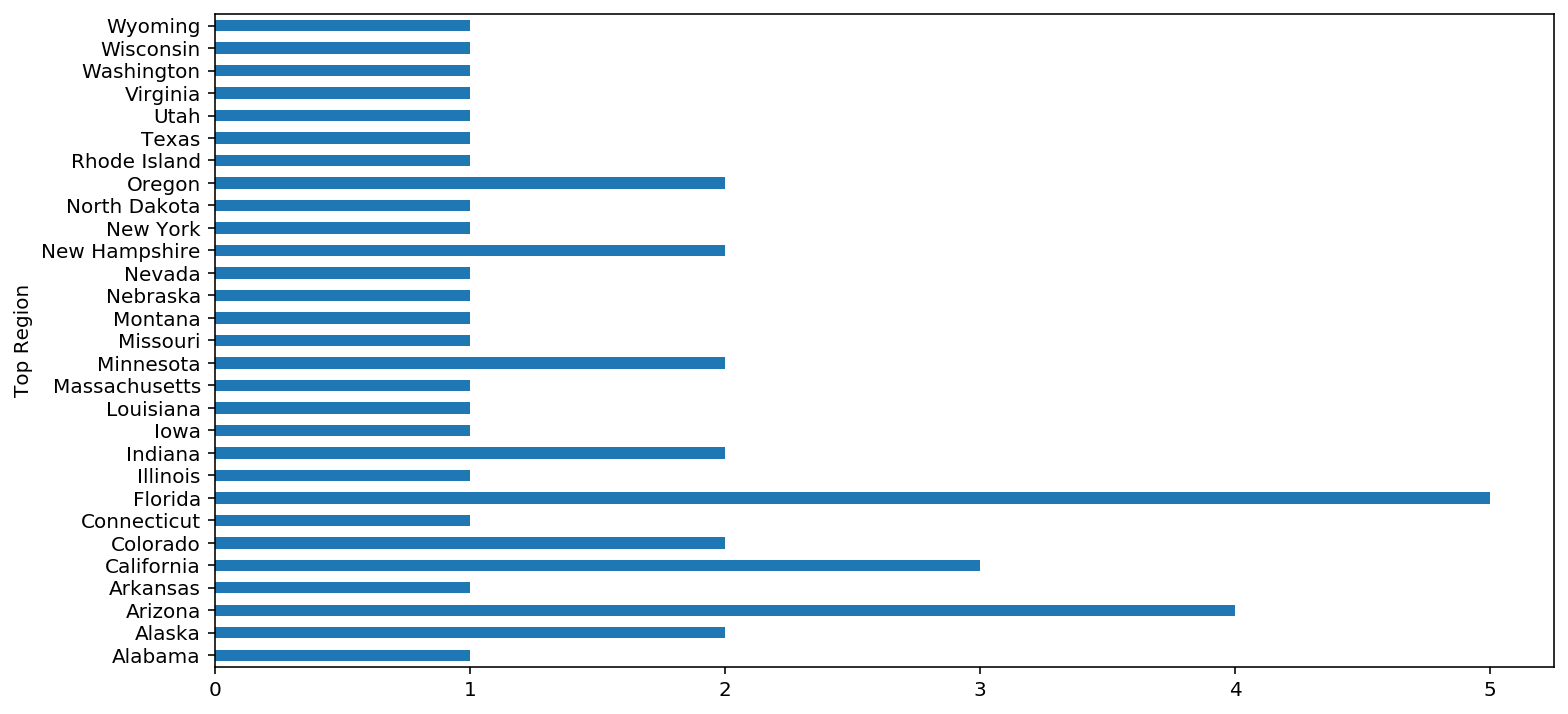

In [34]:
comp = company.groupby("Top Region").count()
comp.loc[(comp.index != 'All')]["NumAds"].plot(kind="barh", figsize=(12,6))

We don't see anything too interesting here, so let's keep going!

,SumDuration,MeanDuration,TotalSpend,TotalImpressions,NumAds,Top Region
OrganizationName,,,,,,
4degre.es Inc,5 days 21:56:32,5 days 21:56:32,110.000000,23219,1,[All]
"A+G, LLC",1 days 12:00:00,0 days 18:00:00,13.500000,7517,2,"[All, All]"
ACRONYM,2933 days 00:21:49,16 days 02:46:16.423076,841.335165,37372783,182,"[Virginia, All, Virginia, All, All, Virginia, ..."
Advocate Advertising Group,5 days 23:39:28,5 days 23:39:28,3.000000,2439,1,[All]
Aisle 518 Strategies LLC,16 days 00:00:00,16 days 00:00:00,361.000000,135584,1,[All]


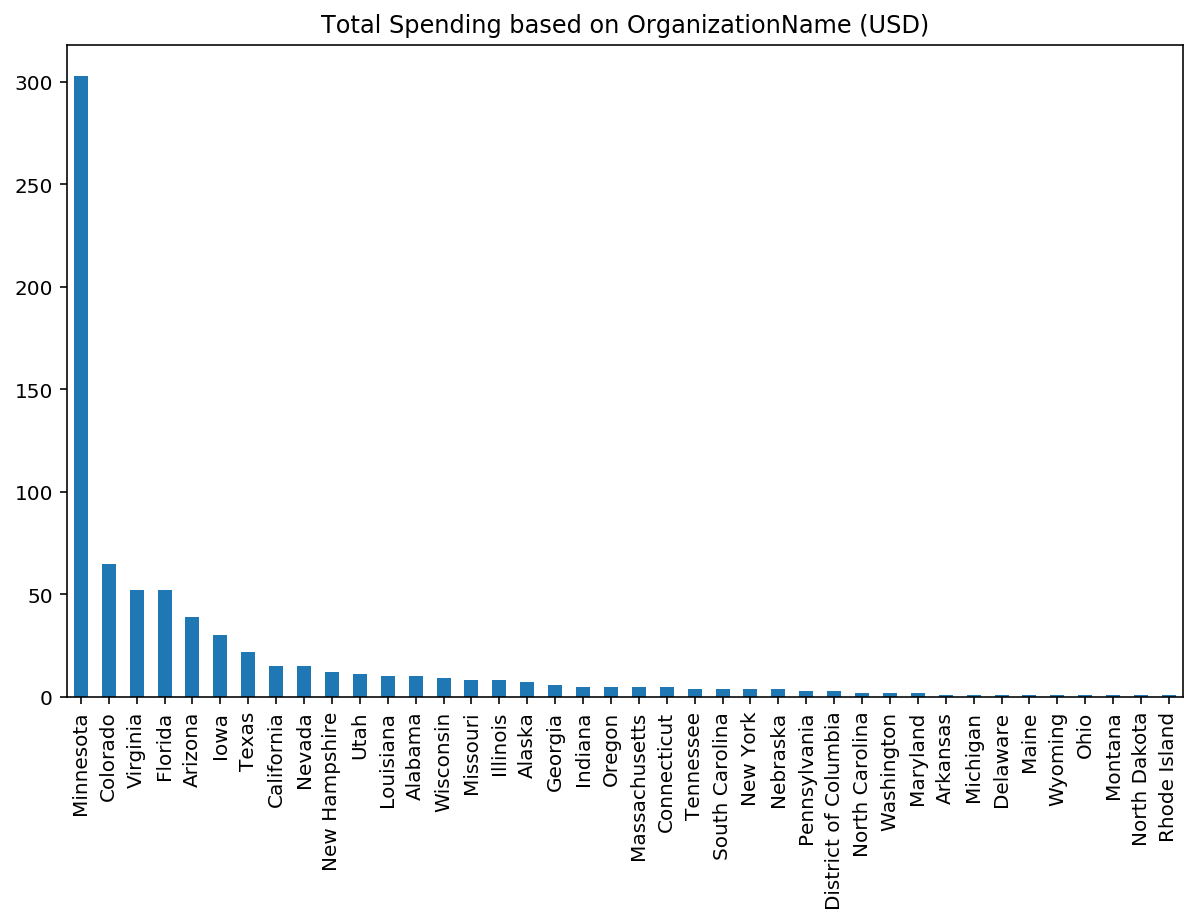

In [35]:
complist = group_by_company(usads)
state = pd.Series(complist["Top Region"].sum()).value_counts()

title = "Total Spending based on OrganizationName (USD)"
state.loc[state.index != "All"].plot(kind="bar", figsize=(10,6), title=title)
complist.head()

Minnisota has the most ads directed at them, but that could be because of UnRestrict Minnesota, the organization that has spent the most on ads. What's even more interesting here is that the top states that majority ads have been directed to in the past two years are __swing states__. Of the top 10 states, only California and Texas are not swing states, but it makes sense because they are the states with the highest population.

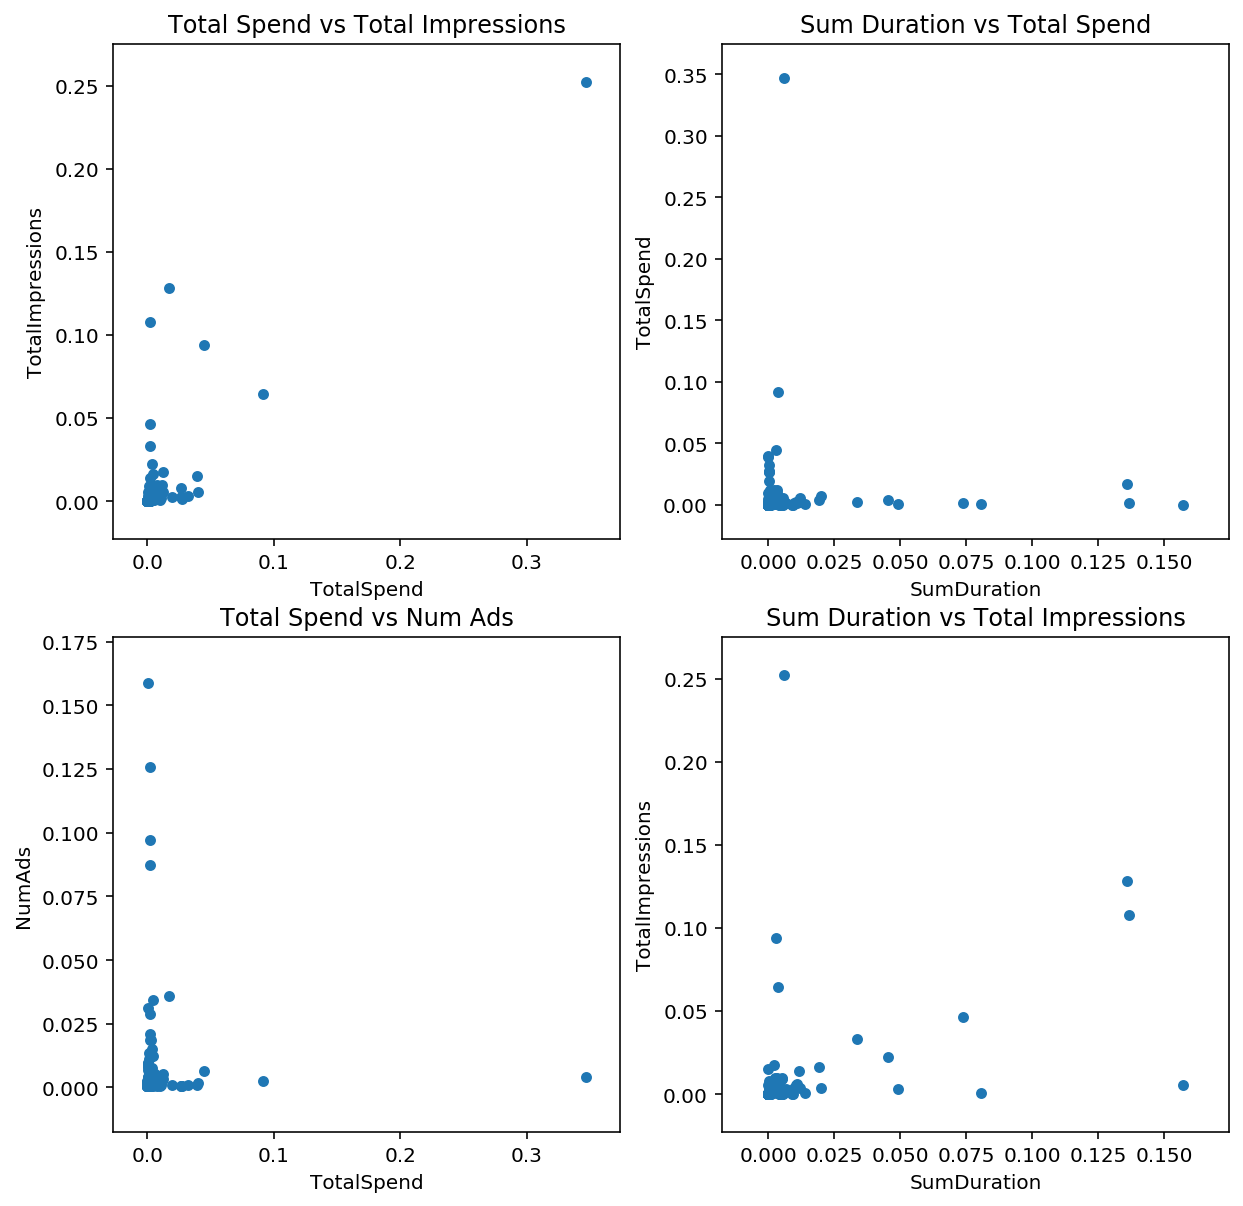

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
company.plot(kind="scatter", x="TotalSpend", y="TotalImpressions", ax=axs[0][0], title='Total Spend vs Total Impressions')
company.plot(kind="scatter", x="SumDuration", y="TotalSpend", ax=axs[0][1], title='Sum Duration vs Total Spend')
company.plot(kind="scatter", x="TotalSpend", y="NumAds", ax=axs[1][0], title='Total Spend vs Num Ads')
company.plot(kind="scatter", x="SumDuration", y="TotalImpressions", ax=axs[1][1], title='Sum Duration vs Total Impressions')

As we can see from the above graphs, it seems like the data has a few outliers for "Total Spend vs Num Ads" and "Sum Duration vs Total Spend" as the data does not reflect SnapChat's advertisement pricing policy, since the ads start at $3000 per month (up to way higher depending on the type as well) , it's impossible that the duration is longer, while the cost is lower than that of other ads with shorter durations.

Source : https://strikesocial.com/blog/snapchat-cost/

### Assessment of Missingness

Does the missingness of RegionID depend on the CountryCode? At first instinct, yes, it should be missing at random because some countries are small enough that it doesn't need a RegionID!

In [37]:
missing = df.copy()
missing = missing.assign(is_null=missing["RegionID"]=='All')
grouped = missing[["CountryCode", "is_null"]].pivot_table(index='CountryCode', columns='is_null', aggfunc='size').apply(lambda x:x / x.sum(), axis=1)

grouped = grouped.fillna(0)
grouped.head()

is_null,False,True
CountryCode,,
argentina,0.000000,1.000000
australia,0.531250,0.468750
austria,0.562500,0.437500
belgium,0.107143,0.892857
brazil,0.000000,1.000000


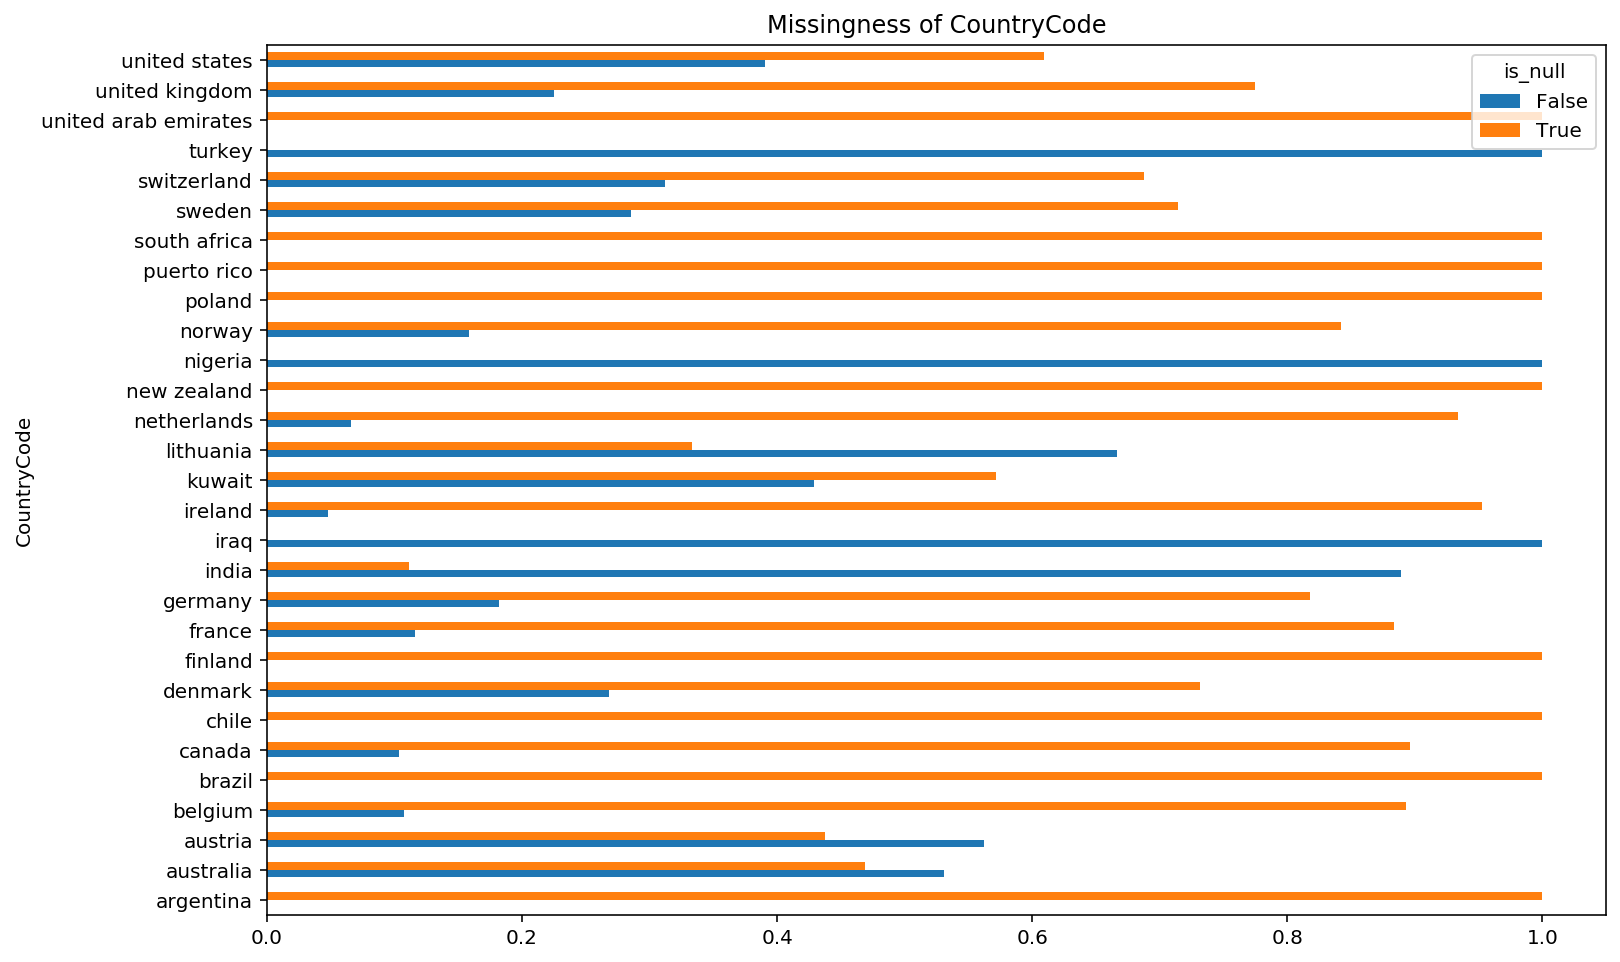

In [38]:
# Let's graph this to see what it tell us! 
title = "Missingness of CountryCode"
grouped.plot(kind="barh", figsize=(12,8), title=title)

Now this is a little hard to look at...so let's run a permutation test to see if the RegionID is more or less likely to be null based on their CountryID. __Is RegionID MAR or MCAR?__  We will set the null hypothesis to say that RegionID is _not_ dependent on CountryID, thus if we shuffle the CountryID columns the TVD should be similar. 

In [39]:
# Using TVD, we are going to iterate through the permutation test.
def missing_perm(column, n_repetitions):
    """
    The purpose of this function is to run a permutation test on the column "RegionID" of the missing dataframe against a given column.
    """
    tvds = []
    for _ in range(n_repetitions):

        shuffled_col = (
             missing[column]
            .sample(replace=False, frac=1)
            .reset_index(drop=True)
        )
        
        shuffled = (
            missing
            .assign(**{
                'shuff': shuffled_col,
                'is_null': missing['RegionID'] == 'All'
            })
        )

        shuffled = (
            shuffled
            .pivot_table(index='is_null', columns='shuff', aggfunc='size')
            .apply(lambda x:x / x.sum(), axis=1)
            .fillna(0)
        )
        
        tvd = shuffled.diff().iloc[-1].abs().sum() / 2

        tvds.append(tvd)
    return tvds

In [40]:
#We are first going to determine the pvalue for CountryCode by calculating the observed
miss = (missing[["CountryCode", "is_null"]]
        .pivot_table(index='is_null', columns='CountryCode', aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
        .fillna(0))
obs = miss.diff().iloc[-1].abs().sum() / 2
obs

0.2935516775441354

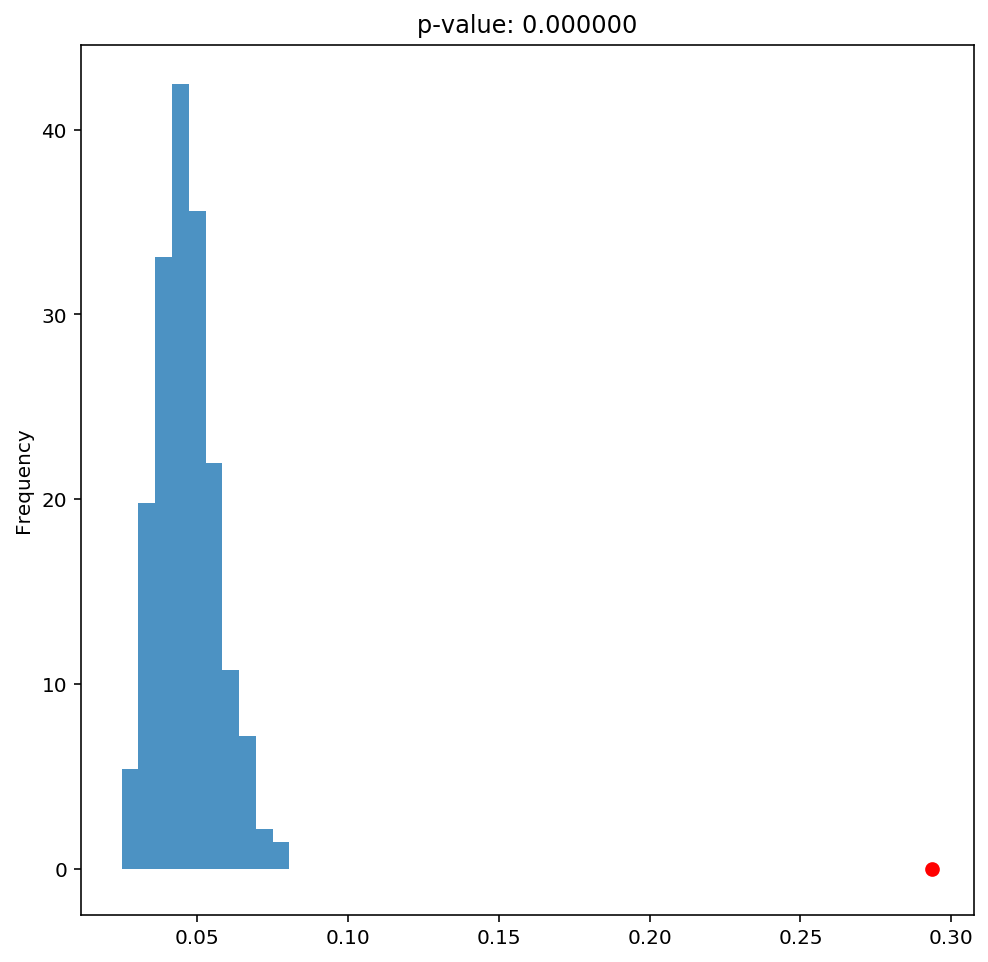

In [41]:
# Lastly, we're going to calculate the pvalue and graph it!
n_repetitions = 500
country_code_tvd = missing_perm('CountryCode', n_repetitions)
pval = np.mean(country_code_tvd > obs)
pd.Series(country_code_tvd).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval, figsize=(8,8))
plt.scatter(obs, 0, color='red', s=40);

According to the permutation test, the p-value if 0! Thus, we can confidently __REJECT__ the null hypothesis and determine RegionID as __missing at random__ in relation to CountryCode.

We are now going to do this again, with a different column. We can set the new null hypothesis to be the following:

The column RegionID's missingness is not dependent on the column LocationType.

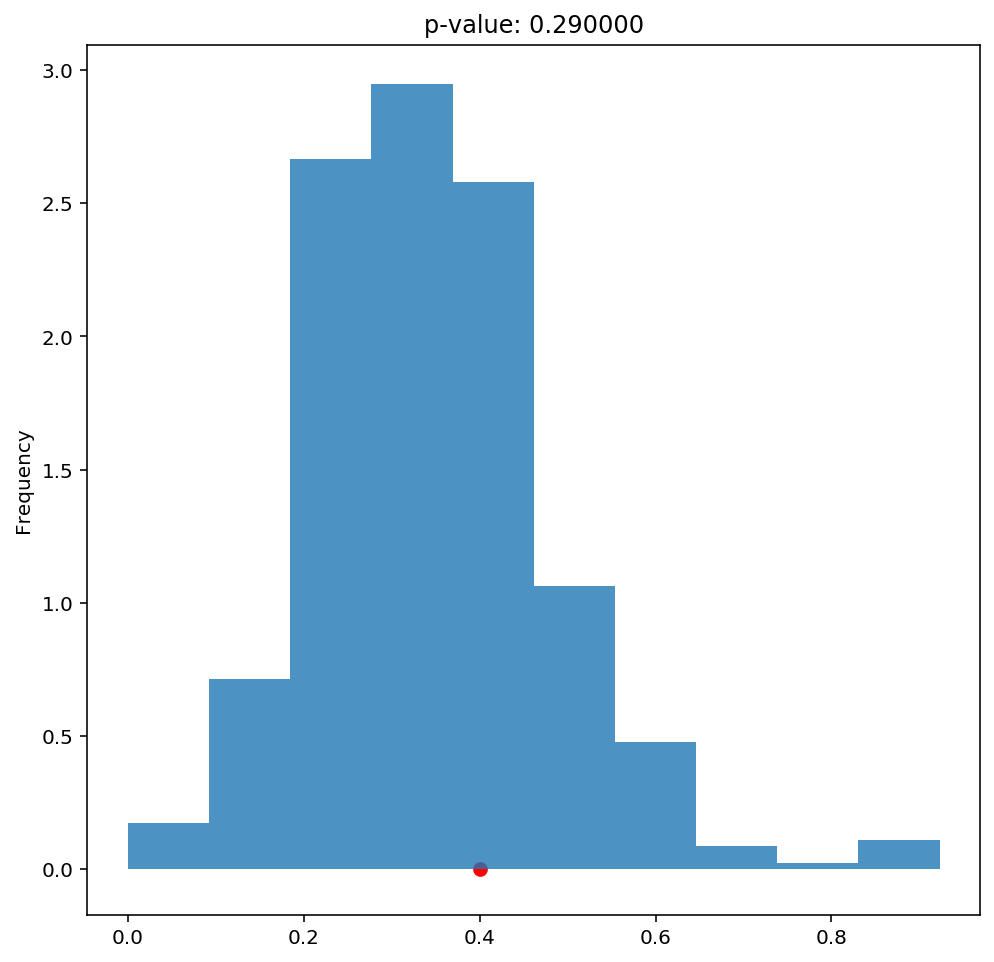

In [42]:
col = 'LocationType'
miss = (missing[[col, "is_null"]]
        .pivot_table(index='is_null', columns=col, aggfunc='size')
        .apply(lambda x:x / x.sum(), axis=1)
        .fillna(0))
obs_impressions = miss.diff().iloc[-1].abs().sum() / 2
obs_impressions

n_repetitions = 500
impressions_tvd = missing_perm(col, n_repetitions)
pval = np.mean(impressions_tvd > obs_impressions)
pd.Series(impressions_tvd).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval, figsize=(8,8))
plt.scatter(obs_impressions, 0, color='red', s=40);

Based on this permutation test, we __CANNOT REJECT__ the null hypothesis, as the pvalue is higher than the significance level of 0.05! Thus, we can say the missingness of RegionID may _not_ be dependent on LocationType.

### Hypothesis Test

Before we decide which test to look at, let's see which columns are correlated with eachother!

In [43]:
from sklearn import preprocessing

In [44]:
# Let's grab all columns that are objects / not floats or ints
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [47]:
def preprocess_1(df):
    '''
    Lists won't work with LabelEncoder, so let's not change the weird strings to lists here
    '''
    # Create a copy to be safe
    df_copy = df.copy()
    
    # Before we can even verify if they merged correctly, we need to convert the start and end date to datetime objects
    df_copy['StartDate'] = pd.to_datetime(df_copy['StartDate'])
    # For End Date, we need to make the NaN values the time we downloaded the file, as it is subject to change if we run this at a later time
    download_date = "2019/11/04 18:31:00Z"
    df_copy['EndDate'] = pd.to_datetime(df_copy['EndDate']).fillna(pd.to_datetime(download_date))
    
    # Gender column targets all genders if NA
    df_copy['Gender'] = df_copy['Gender'].fillna('All')
    
    # AgeBracket column targets all ages if NA
    df_copy['AgeBracket'] = df_copy['AgeBracket'].fillna('All')
    
    # All other NaNs that are agnostic based on the readme.txt are filled here
    df_copy['RegionID'] = df_copy['RegionID'].fillna('All')
    df_copy['ElectoralDistrictID'] = df_copy['ElectoralDistrictID'].fillna('All')
    df_copy['LatLongRad'] = df_copy['LatLongRad'].fillna('All')
    df_copy['MetroID'] = df_copy['MetroID'].fillna('All')
    df_copy['OsType'] = df_copy['OsType'].fillna('All')
    df_copy['Language'] = df_copy['Language'].fillna('All')
    df_copy['AdvancedDemographics'] = df_copy['AdvancedDemographics'].fillna('All')
    df_copy['Targeting Connection Type'] = df_copy['Targeting Connection Type'].fillna('All')
    df_copy['Targeting Carrier (ISP)'] = df_copy['Targeting Carrier (ISP)'].fillna('All')
    
    return df_copy

# First let's read in both of the dfs again
df_2018 = pd.read_csv('PoliticalAds2018.csv')
df_2019 = pd.read_csv('PoliticalAds2019.csv')
# Now to concat them
df_hypothesis = pd.concat([df_2018, df_2019])
df_hypothesis = preprocess_1(df_hypothesis)

In [48]:
# Encode categorical values
label_encoder = preprocessing.LabelEncoder()
df_hypothesis = df_hypothesis.fillna('NaN')

# Create new duration column
df_hypothesis = df_hypothesis.assign(**{
    'Duration': (df_hypothesis['EndDate'] - df_hypothesis['StartDate']).apply(lambda x: x.days)
})

for col in categorical_columns:
    df_hypothesis[col] = label_encoder.fit_transform(df_hypothesis[col]).astype('float64')

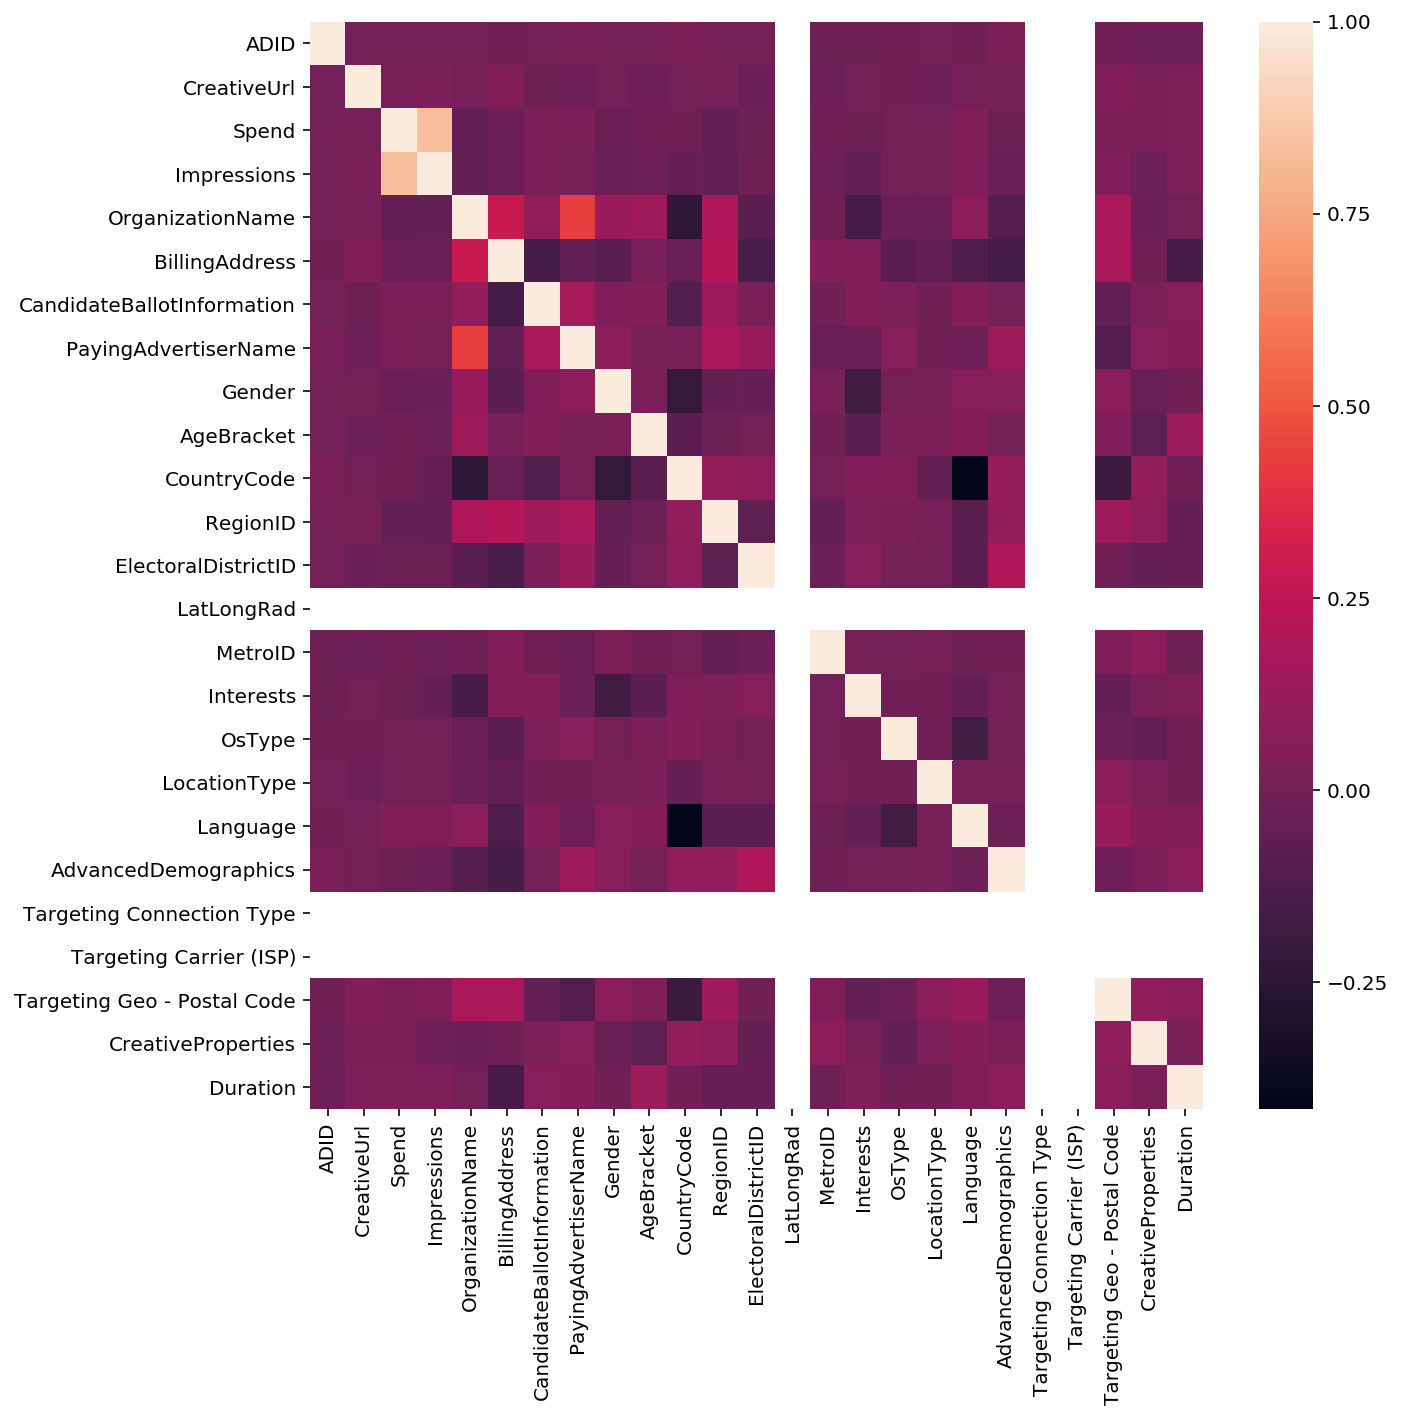

In [49]:
# calculate correlations for each category
corr = df_hypothesis.corr()
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(corr)

I'm interested in seeing whether the correlation between Duration and Impressions is actually true, let's do a permutation test and see if the shorter campaigns get less views than the longer campaigns!

Set p-value threshold to be 0.05.

__Null Hypothesis__ : The observed mean impressions from campaigns labeled as "short," are less than the Impressions from campaigns labeled as "long." Meaning that the difference in means between campaigns labeled as "short" and "long" should be relatively high.

__Alternative Hypothesis__ : The mean difference between campaigns labeled as "short" and "long" should be smaller than the observed value, as internet culture usually promotes short-term popularity, and the campaigns will lose attention as time goes on, meaning that the mean differences should be similar

__Definitions__ : 
- "Long" campaigns are campaigns greater than 30 days.
- "Short" campaigns are campaigns less or equal to 30 days.

__Test Statistic__ : 
- Difference in means between the "long" and "short" campaigns

In [50]:
df_short = df_hypothesis[df_hypothesis['Duration'] <= 30]
obs_short = df_short.Impressions.mean()

df_long = df_hypothesis[df_hypothesis['Duration'] > 30]
obs_long = df_long.Impressions.mean()

obs_diff = abs(obs_long - obs_short)

print('(obs_short, obs_long) : {}'.format((obs_short, obs_long)))
print('Observed mean difference is : {}'.format(obs_diff))

(obs_short, obs_long) : (518196.2168059424, 940500.0519247985)
Observed mean difference is : 422303.8351188561


In [59]:
n_repetitions = 3000

diffs = []
for _ in range(n_repetitions):
    
    # shuffle the duration and impressions columns
    shuffled_Impressions = (
        df_hypothesis['Impressions']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    shuffled_Duration = (
        df_hypothesis['Duration']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        df_hypothesis
        .assign(**{
            'Shuffled Impressions' : shuffled_Impressions,
            'Shuffled Duration' : shuffled_Duration
        })
    )
    
    # compute the group differences (test statistic!)
    diff_shuffled = (
        abs(
            shuffled['Shuffled Impressions'].mean() - shuffled['Shuffled Duration'].mean()
        )
    )
    
    # add it to the list of results
    diffs.append(diff_shuffled)

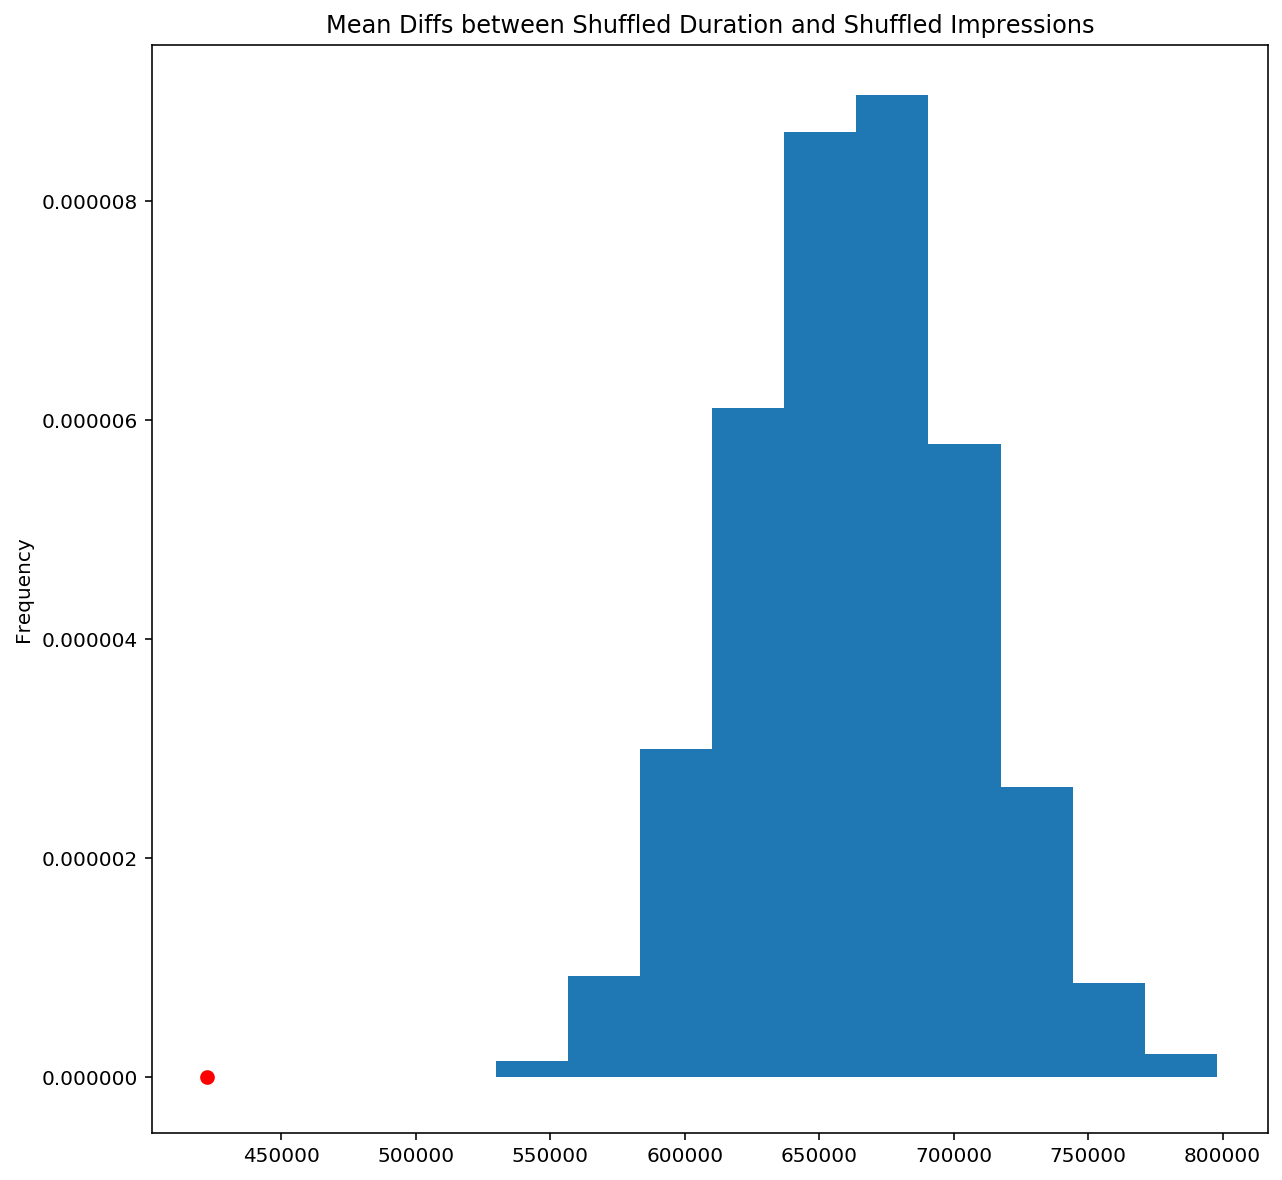

In [60]:
title = 'Mean Diffs between Shuffled Duration and Shuffled Impressions'
pd.Series(diffs).plot(kind='hist', density=True, title=title)
plt.scatter(obs_diff, 0, color='red', s=40);

In [65]:
pval = np.mean(diffs >= np.array(obs_diff))
print("The pval for this test is {}".format(pval))

The pval for this test is 1.0


Turns out that we fail to reject the null hypothesis by a huge margin! It seems like duration and impressions are heavily correlated, and the data properly represents that.